In [15]:
import torch

from project_zakup.фыва import data_sarima

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.5.1+cpu
False
None


16:48:16 - cmdstanpy - INFO - Chain [1] start processing


2024-10-01


16:48:16 - cmdstanpy - INFO - Chain [1] done processing
16:48:16 - cmdstanpy - INFO - Chain [1] start processing
16:48:16 - cmdstanpy - INFO - Chain [1] done processing


date
2018-01-01    1985.0
2018-02-01    1365.0
2018-03-01    4362.0
2018-04-01    1500.0
2018-05-01    3285.0
               ...  
2024-05-01    6243.0
2024-06-01    2513.0
2024-07-01    2490.0
2024-08-01    3365.0
2024-09-01    2366.0
Freq: MS, Name: product_count, Length: 81, dtype: float64
✅Прогноз построен для категории 2c281485-37d2-11e4-8d43-00155d031202


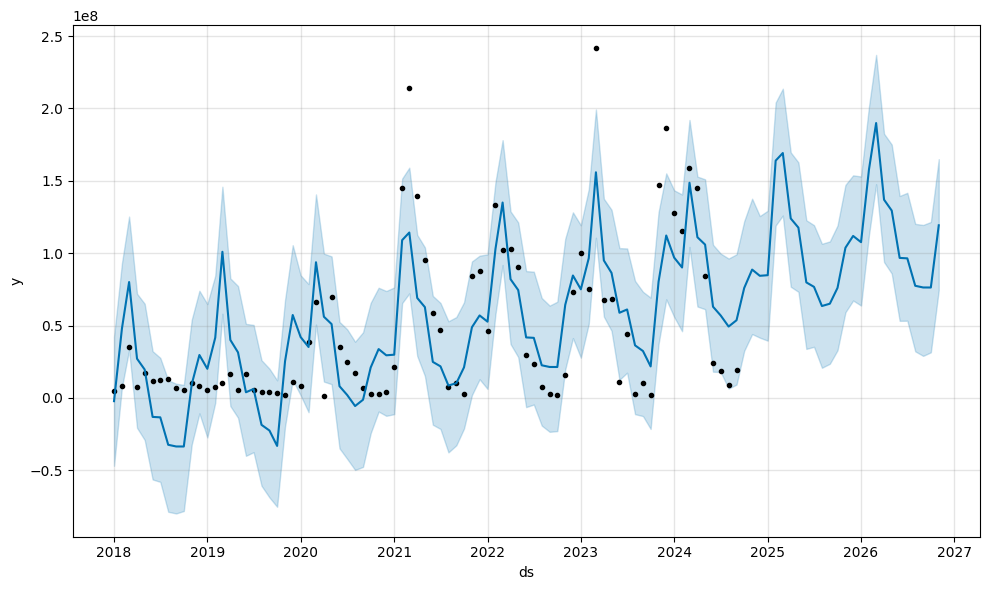

In [22]:
from prophet import Prophet
import warnings
import pandas as pd

warnings.filterwarnings("ignore")



data = pd.read_csv('data_month.csv')
data = data.sort_values('date')
dates = data['date'].unique()
min_date = dates[-2]
print(min_date)

forecast_df = pd.DataFrame(columns=['month_date', 'category_id', 'fact_count', 'fact_cost', 'final_count_forecast', 'final_cost_forecast', 'date_load'])
for i in data.category_id.unique():
    try:
        df = data.copy()

        df = df.where(df.category_id == i).dropna()

        a = df.sort_values('date')

        df.set_index('date', inplace=True)
        df = df.sort_index()
        df.index = pd.to_datetime(df.index)

        df.product_count = df.product_count.astype(float)
        df.product_cost = df.product_cost.astype(float)
        df = df.asfreq('MS')
        df = df.fillna(0)

        train_data = df.iloc[:-2]

        if len(train_data) < 12:
            print(
                f"❌Недостаточно данных для построения прогноза по категории {i}. "
                f"Длина обучающего набора: {len(train_data)}"
            )
            continue

        test_start_date = df.index[-2]
        test_end_date = test_start_date + pd.DateOffset(
            months=25
        )
        test_dates = pd.date_range(test_start_date, test_end_date, freq="MS")

        if test_dates.min() < pd.to_datetime(min_date):
            print(f"❌Устаревшие данные для построения прогноза по категории {i}.")
            continue

        m1 = Prophet()

        count_data = pd.DataFrame(
            {
            'ds' : pd.to_datetime(train_data.index),
            'y': train_data['product_count']
            })

        count_data = count_data.sort_values('ds')

        m1.fit(count_data)

        future_count = m1.make_future_dataframe(periods=26, freq="MS")
        forecast_count = m1.predict(future_count)

        m2 = Prophet()
        cost_data = pd.DataFrame(
            {
            'ds' : pd.to_datetime(train_data.index),
            'y': train_data['product_cost']
            })
        cost_data = cost_data.sort_values('ds')

        m2.fit(cost_data)

        future_cost = m2.make_future_dataframe(periods=26, freq="MS")
        forecast_cost = m2.predict(future_cost)


        forecast = pd.DataFrame(
            {
                "month_date": forecast_count.iloc[:-24]['ds'],
                "category_id": i,
                "fact_count": train_data['product_count'],
                "fact_cost": train_data['product_cost'],
                "final_count_forecast": forecast_count.iloc[:-24]['yhat'].apply(lambda x: 0 if x < 0 else x),
                "final_cost_forecast": forecast_cost.iloc[:-24]['yhat'].apply(lambda x: 0 if x < 0 else x),
                'date_load': pd.to_datetime(pd.Timestamp.now().strftime("%Y-%m-%d"))
            }
        )
        print(train_data['product_count'])
        m2.plot(forecast_cost)


        forecast_df = pd.concat([forecast_df, forecast])
        print(f"✅Прогноз построен для категории {i}")
        break

    except Exception as e:
        print(f"❌Невозможно построить прогноз для категории {i}: {e}")
        continue

In [20]:
forecast

,month_date,category_id,fact_count,fact_cost,final_count_forecast,final_cost_forecast,date_load
0,2018-01-01,2c281485-37d2-11e4-8d43-00155d031202,NaN,NaN,6.825212,0.000000e+00,2024-12-11
1,2018-02-01,2c281485-37d2-11e4-8d43-00155d031202,NaN,NaN,6076.496209,4.791358e+07,2024-12-11
2,2018-03-01,2c281485-37d2-11e4-8d43-00155d031202,NaN,NaN,13208.682792,8.004427e+07,2024-12-11
3,2018-04-01,2c281485-37d2-11e4-8d43-00155d031202,NaN,NaN,3314.695149,2.707422e+07,2024-12-11
4,2018-05-01,2c281485-37d2-11e4-8d43-00155d031202,NaN,NaN,1529.858669,1.955126e+07,2024-12-11
...,...,...,...,...,...,...,...
2024-05-01 00:00:00,NaT,2c281485-37d2-11e4-8d43-00155d031202,6243.0,84337525.81,NaN,NaN,2024-12-11
2024-06-01 00:00:00,NaT,2c281485-37d2-11e4-8d43-00155d031202,2513.0,24351266.56,NaN,NaN,2024-12-11
2024-07-01 00:00:00,NaT,2c281485-37d2-11e4-8d43-00155d031202,2490.0,18421019.84,NaN,NaN,2024-12-11
2024-08-01 00:00:00,NaT,2c281485-37d2-11e4-8d43-00155d031202,3365.0,8808130.13,NaN,NaN,2024-12-11


In [1]:
from dns_support import get_variables

get_variables(host='https://airflow-oakp-dev.fcs.dns-shop.ru')

In [8]:
from dns_sources import ClickHouse

ch = ClickHouse(
    host='adm-fcs-ch03.dns-shop.ru',
    user='oakp_service',
    password='UpBw6cj2zjK1',
)

In [26]:
month = ch.execute('''
    SELECT
        date_trunc('month', predict.day_date)::date as date_1,
        predict.forecast_type as algoritm_name,
        predict.category_4_id as category_id,
        predict.responsible_team_id as responsible_team_id,
        predict.delivery_channel_id as delivery_channel_id,
        sum(predict.day_count_forecast) as predict_count,
        sum(plan.count_sum) as plan_count,
        sum(predict.day_sale_forecast) as predict_sale,
        sum(plan.no_vat_sum) as plan_sale,
        sum(predict.day_cost_forecast) as predict_cost,
        sum(plan.no_vat_cost_sum) as plan_cost,
        sum(predict.day_profit_forecast) as predict_profit,
        sum(plan.no_vat_profit_sum) as plan_profit
    FROM
        data_mart.category_day_forecast as predict
    INNER JOIN
        data_mart.category_day_decomposition_plan as plan
        ON plan.category_4_id = predict.category_4_id
        AND plan.delivery_channel_id = predict.delivery_channel_id
        AND plan.responsible_team_id = predict.responsible_team_id
        AND plan.date_day = predict.day_date
    GROUP BY
        date_trunc('month', predict.day_date)::date,
        category_id,
        predict.responsible_team_id,
        predict.delivery_channel_id,
        algoritm_name
)

SELECT
    plan_predict.date_1 as date_month,
    extract(month from date_1) as month_number,
    CASE
       WHEN plan_predict.responsible_team_id = '9296c715-2f6b-11ee-8edb-00155dd9e62d' THEN 'РФ команда'
       ELSE 'CTM команда'
       END as responsible_team_name,
    CASE
       WHEN plan_predict.delivery_channel_id = '69f2d05b-880c-11e0-a3c6-00155d030b07' THEN 'РФ'
       ELSE 'ВЭД'
       END as delivery_channel_name,
    category.rf_category_name as rf_category_name,
    category.rf_group_name as rf_group_name,
    category.rf_naprav_name as rf_naprav_name,
    category.rf_depart_name as rf_depart_name,
    category.stm_category_name as stm_category_name,
    category.stm_group_name as stm_group_name,
    category.stm_naprav_name as stm_naprav_name,
    category.stm_depart_name as stm_depart_name,
    plan_predict.algoritm_name as algoritm_name,
    plan_predict.plan_profit as plan_profit,
    plan_predict.predict_profit as predict_profit,
    plan_predict.plan_count as plan_count,
    plan_predict.predict_count as predict_count,
    plan_predict.plan_sale as plan_sale,
    plan_predict.predict_sale as predict_sale,
    plan_predict.plan_cost as plan_cost,
    plan_predict.predict_cost as predict_cost
FROM
    plan_predict
INNER JOIN
    category ON category.rf_category_id = plan_predict.category_id
;
''')

ServerException: Code: 62.
DB::Exception: Syntax error: failed at position 1254 (')') (line 30, col 1): )

SELECT
    plan_predict.date_1 as date_month,
    extract(month from date_1) as month_number,
    CASE
       WHEN plan_predict.responsible_team_id = '9296c7. Unmatched parentheses: ). Stack trace:

0. DB::Exception::Exception(DB::Exception::MessageMasked&&, int, bool) @ 0xe22f215 in /usr/bin/clickhouse
1. ? @ 0x8dd876d in /usr/bin/clickhouse
2. DB::parseQueryAndMovePosition(DB::IParser&, char const*&, char const*, String const&, bool, unsigned long, unsigned long) @ 0x1518e05f in /usr/bin/clickhouse
3. ? @ 0x13cc547b in /usr/bin/clickhouse
4. DB::executeQuery(String const&, std::shared_ptr<DB::Context>, bool, DB::QueryProcessingStage::Enum) @ 0x13cc4e4d in /usr/bin/clickhouse
5. DB::TCPHandler::runImpl() @ 0x14a98b6c in /usr/bin/clickhouse
6. DB::TCPHandler::run() @ 0x14aae379 in /usr/bin/clickhouse
7. Poco::Net::TCPServerConnection::start() @ 0x179f4f14 in /usr/bin/clickhouse
8. Poco::Net::TCPServerDispatcher::run() @ 0x179f613b in /usr/bin/clickhouse
9. Poco::PooledThread::run() @ 0x17b7d9c7 in /usr/bin/clickhouse
10. Poco::ThreadImpl::runnableEntry(void*) @ 0x17b7b3fd in /usr/bin/clickhouse
11. ? @ 0x7f3a79a9f802 in ?
12. ? @ 0x7f3a79a3f450 in ?


In [47]:
from dns_support import get_variables
dev = "https://airflow-oakp-dev.fcs.dns-shop.ru"
get_variables(host=dev)

In [48]:
data = ch_fcs().execute_to_df('''
with products AS (
    SELECT
        product.id as product_id,
        product.category_4_id as category_id,
        product.delivery_channel_id as delivery_channel_id,
        product.responsible_team_id as responsible_team_id
    FROM
        dict.product as product
    WHERE
        product.category_4_id <> '00000000-0000-0000-0000-000000000000'
        and product.delivery_channel_id <> '00000000-0000-0000-0000-000000000000'
        and product.responsible_team_id <> '00000000-0000-0000-0000-000000000000'
), sales AS (
    SELECT
        toYear(sales.`Период`) as year_number,
        sales.`Номенклатура` as product_id,
        toISOWeek(sales.`Период`) as month_number,
        sum(sales.`Себестоимость`) as fact_cost,
        sum(sales.`Количество`) as fact_count,
        sum(sales.`Продажа`) as fact_sales,
        sum(sales.`Продажа`) - sum(sales.`Себестоимость`) as fact_profit
    FROM
        RN.Schet_90 as sales
    WHERE
        toYear(sales.`Период`) > toYear(sales.`Период`) - 3
        AND toYear(sales.`Период`) < toYear(now())
    GROUP BY
        product_id,
        year_number,
        month_number
)

SELECT
    year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id,
    sum(sales.fact_cost) as fact_cost,
    sum(sales.fact_count) as fact_count,
    sum(sales.fact_profit) as fact_profit,
    sum(sales.fact_sales) as fact_sales
FROM
    sales
INNER JOIN
        products ON products.product_id = sales.product_id
where products.product_id = 'be8c69f7-5cfe-11ee-914b-00155d8ed20b'
and products.delivery_channel_id = 'e0669251-8274-11e0-b9c6-00155d030b07'
and products.responsible_team_id = '9296c715-2f6b-11ee-8edb-00155dd9e62d'
    year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id
''')

ServerException: Code: 62.
DB::Exception: Syntax error: failed at position 1830 ('year_number') (line 51, col 5): year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id
. Expected one of: token, DoubleColon, OR, AND, BETWEEN, NOT BETWEEN, LIKE, ILIKE, NOT LIKE, NOT ILIKE, REGEXP, IN, NOT IN, GLOBAL IN, GLOBAL NOT IN, MOD, DIV, IS NULL, IS NOT NULL, alias, AS, GROUP BY, WITH, HAVING, WINDOW, ORDER BY, LIMIT, OFFSET, SETTINGS, UNION, EXCEPT, INTERSECT, INTO OUTFILE, FORMAT, end of query. Stack trace:

0. DB::Exception::Exception(DB::Exception::MessageMasked&&, int, bool) @ 0xe22f215 in /usr/bin/clickhouse
1. ? @ 0x8dd876d in /usr/bin/clickhouse
2. DB::parseQueryAndMovePosition(DB::IParser&, char const*&, char const*, String const&, bool, unsigned long, unsigned long) @ 0x1518e05f in /usr/bin/clickhouse
3. ? @ 0x13cc547b in /usr/bin/clickhouse
4. DB::executeQuery(String const&, std::shared_ptr<DB::Context>, bool, DB::QueryProcessingStage::Enum) @ 0x13cc4e4d in /usr/bin/clickhouse
5. DB::TCPHandler::runImpl() @ 0x14a98b6c in /usr/bin/clickhouse
6. DB::TCPHandler::run() @ 0x14aae379 in /usr/bin/clickhouse
7. Poco::Net::TCPServerConnection::start() @ 0x179f4f14 in /usr/bin/clickhouse
8. Poco::Net::TCPServerDispatcher::run() @ 0x179f613b in /usr/bin/clickhouse
9. Poco::PooledThread::run() @ 0x17b7d9c7 in /usr/bin/clickhouse
10. Poco::ThreadImpl::runnableEntry(void*) @ 0x17b7b3fd in /usr/bin/clickhouse
11. ? @ 0x7f3a79a9f802 in ?
12. ? @ 0x7f3a79a3f450 in ?


In [37]:
df = data.groupby(['month_number', 'category_id', 'delivery_channel_id', 'responsible_team_id'], as_index=False).agg({
    'fact_profit': 'median',
    'fact_cost': 'median',
    'fact_sales': 'median',
    'fact_count': 'median'
})

In [38]:
df

,month_number,category_id,delivery_channel_id,responsible_team_id,fact_profit,fact_cost,fact_sales,fact_count
0,1,003294ba-2bcf-11ec-8f04-00155d8ed20c,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,5349.195,26778.305,32127.5,134.0
1,1,0054ab89-4708-11ee-9130-00155d8ed20b,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,1550263.165,11911354.04,13161122.68,2282.0
2,1,0054ab89-4708-11ee-9130-00155d8ed20b,e0669251-8274-11e0-b9c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,2136062.46,11179629.91,13932828.0,4068.0
3,1,0070bcf5-dd2b-11e2-9b85-00155d030b1f,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,452569.995,800893.54,1189337.5,945.0
4,1,0070bcf5-dd2b-11e2-9b85-00155d030b1f,e0669251-8274-11e0-b9c6-00155d030b07,80bb827d-2f6b-11ee-8edb-00155dd9e62d,2063871.26,3031089.74,5094961.0,1449.5
...,...,...,...,...,...,...,...,...
129689,53,fe297069-8f61-11ea-a20d-00155df1b805,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,149.49,224.51,374.0,8.0
129690,53,fed241b2-54a1-11ef-924c-0050569d5825,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,12119.34,23792.66,35912.0,33.5
129691,53,feeb8e87-76b3-11e4-a8f0-00155d031202,69f2d05b-880c-11e0-a3c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,64113.465,505637.035,569750.5,29.0
129692,53,ff82f0d1-1976-11ee-9108-00155d8ed20c,e0669251-8274-11e0-b9c6-00155d030b07,9296c715-2f6b-11ee-8edb-00155dd9e62d,315056.42,963535.58,1278592.0,8.0


In [45]:
from utils import pg_fspb, ch_fcs
import pandas as pd


# Запрос на получение недельных данных по закупкам (количество товаров и сумма без НДС)
def qwerty():
    df = ch_fcs().execute_to_df('''
with products AS (
    SELECT
        product.id as product_id,
        product.category_4_id as category_id,
        product.delivery_channel_id as delivery_channel_id,
        product.responsible_team_id as responsible_team_id
    FROM
        dict.product as product
), sales AS (
    SELECT
        toYear(sales.`Период`) as year_number,
        sales.`Номенклатура` as product_id,
        toMonth(sales.`Период`) as month_number,
        sum(sales.`Себестоимость`) as fact_cost,
        sum(sales.`Количество`) as fact_count,
        sum(sales.`Продажа`) as fact_sales,
        sum(sales.`Продажа`) - sum(sales.`Себестоимость`) as fact_profit
    FROM
        RN.Schet_90 as sales
    WHERE
        toYear(sales.`Период`) > toYear(sales.`Период`) - 3
    GROUP BY
        product_id,
        year_number,
        month_number
)

SELECT
    year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id,
    sum(sales.fact_cost),
    sum(sales.fact_count),
    sum(sales.fact_profit),
    sum(sales.fact_sales)
FROM
    sales
INNER JOIN
        products ON products.product_id = sales.product_id
GROUP BY
    year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id

        ''')
    return df

df = qwerty()

In [50]:
from dns_support import get_variables
dev = "https://airflow-oakp-dev.fcs.dns-shop.ru"
get_variables(host=dev)

In [51]:
ch_fcs().execute_to_df('''select 1''')

ServerException: Code: 62.
DB::Exception: Syntax error: failed at position 1829 ('year_number') (line 50, col 5): year_number,
    month_number,
    products.category_id,
    products.delivery_channel_id,
    products.responsible_team_id. Expected one of: token, DoubleColon, OR, AND, BETWEEN, NOT BETWEEN, LIKE, ILIKE, NOT LIKE, NOT ILIKE, REGEXP, IN, NOT IN, GLOBAL IN, GLOBAL NOT IN, MOD, DIV, IS NULL, IS NOT NULL, alias, AS, GROUP BY, WITH, HAVING, WINDOW, ORDER BY, LIMIT, OFFSET, SETTINGS, UNION, EXCEPT, INTERSECT, INTO OUTFILE, FORMAT, end of query. Stack trace:

0. DB::Exception::Exception(DB::Exception::MessageMasked&&, int, bool) @ 0xe22f215 in /usr/bin/clickhouse
1. ? @ 0x8dd876d in /usr/bin/clickhouse
2. DB::parseQueryAndMovePosition(DB::IParser&, char const*&, char const*, String const&, bool, unsigned long, unsigned long) @ 0x1518e05f in /usr/bin/clickhouse
3. ? @ 0x13cc547b in /usr/bin/clickhouse
4. DB::executeQuery(String const&, std::shared_ptr<DB::Context>, bool, DB::QueryProcessingStage::Enum) @ 0x13cc4e4d in /usr/bin/clickhouse
5. DB::TCPHandler::runImpl() @ 0x14a98b6c in /usr/bin/clickhouse
6. DB::TCPHandler::run() @ 0x14aae379 in /usr/bin/clickhouse
7. Poco::Net::TCPServerConnection::start() @ 0x179f4f14 in /usr/bin/clickhouse
8. Poco::Net::TCPServerDispatcher::run() @ 0x179f613b in /usr/bin/clickhouse
9. Poco::PooledThread::run() @ 0x17b7d9c7 in /usr/bin/clickhouse
10. Poco::ThreadImpl::runnableEntry(void*) @ 0x17b7b3fd in /usr/bin/clickhouse
11. ? @ 0x7f3a79a9f802 in ?
12. ? @ 0x7f3a79a3f450 in ?


In [ ]:
df

In [2]:
conn = pg_fspb()

print(conn.user, conn.password)

None None


,date,category_id,product_count,product_cost
1907,2018-01-01,fd721048-70e6-11e2-b24e-00155d030b1f,101761.0,3.863909e+08
2919,2018-02-01,fd721048-70e6-11e2-b24e-00155d030b1f,68140.0,2.554648e+08
618,2018-03-01,fd721048-70e6-11e2-b24e-00155d030b1f,62473.0,2.158053e+08
1653,2018-04-01,fd721048-70e6-11e2-b24e-00155d030b1f,59862.0,2.527954e+08
2326,2018-05-01,fd721048-70e6-11e2-b24e-00155d030b1f,50443.0,2.241151e+08
...,...,...,...,...
590,2024-07-01,fd721048-70e6-11e2-b24e-00155d030b1f,30929.0,6.800957e+07
2797,2024-08-01,fd721048-70e6-11e2-b24e-00155d030b1f,1065749.0,3.526543e+09
915,2024-09-01,fd721048-70e6-11e2-b24e-00155d030b1f,736746.0,2.585902e+09
725,2024-10-01,fd721048-70e6-11e2-b24e-00155d030b1f,846594.0,2.527727e+09


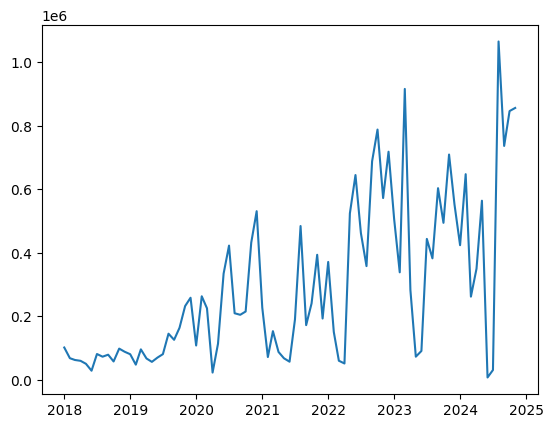

In [34]:
import matplotlib.pyplot as plt

data = pd.read_csv('data_month_dep_2.csv')
df = data.where(data.category_id == 'fd721048-70e6-11e2-b24e-00155d030b1f').dropna()
df.product_count = df.product_count.astype(float)
df.date = pd.to_datetime(df.date)
df = df.sort_values('date')
plt.plot(df.date, df.product_count)
df

In [21]:
data

,week_date,category_id,responsible_team_id,delivery_channel_id,final_count_forecast,final_cost_forecast,date_load
0,2024-09-01,fd721041-70e6-11e2-b24e-00155d030b1f,9296c715-2f6b-11ee-8edb-00155dd9e62d,e0669251-8274-11e0-b9c6-00155d030b07,0.0,2.091675e+06,2024-12-04
1,2024-09-08,fd721041-70e6-11e2-b24e-00155d030b1f,9296c715-2f6b-11ee-8edb-00155dd9e62d,e0669251-8274-11e0-b9c6-00155d030b07,0.0,1.557267e+07,2024-12-04
2,2024-09-15,fd721041-70e6-11e2-b24e-00155d030b1f,9296c715-2f6b-11ee-8edb-00155dd9e62d,e0669251-8274-11e0-b9c6-00155d030b07,0.0,2.049683e+07,2024-12-04
3,2024-09-22,fd721041-70e6-11e2-b24e-00155d030b1f,9296c715-2f6b-11ee-8edb-00155dd9e62d,e0669251-8274-11e0-b9c6-00155d030b07,0.0,0.000000e+00,2024-12-04
4,2024-09-29,fd721041-70e6-11e2-b24e-00155d030b1f,9296c715-2f6b-11ee-8edb-00155dd9e62d,e0669251-8274-11e0-b9c6-00155d030b07,0.0,0.000000e+00,2024-12-04
...,...,...,...,...,...,...,...
7915,2025-10-19,c83bc194-7722-11ef-926f-0050569d5825,9296c715-2f6b-11ee-8edb-00155dd9e62d,69f2d05b-880c-11e0-a3c6-00155d030b07,0.0,0.000000e+00,2024-12-04
7916,2025-10-26,c83bc194-7722-11ef-926f-0050569d5825,9296c715-2f6b-11ee-8edb-00155dd9e62d,69f2d05b-880c-11e0-a3c6-00155d030b07,0.0,0.000000e+00,2024-12-04
7917,2025-11-02,c83bc194-7722-11ef-926f-0050569d5825,9296c715-2f6b-11ee-8edb-00155dd9e62d,69f2d05b-880c-11e0-a3c6-00155d030b07,0.0,0.000000e+00,2024-12-04
7918,2025-11-09,c83bc194-7722-11ef-926f-0050569d5825,9296c715-2f6b-11ee-8edb-00155dd9e62d,69f2d05b-880c-11e0-a3c6-00155d030b07,0.0,0.000000e+00,2024-12-04


In [33]:
data_sarima

,month_date,category_id,final_count_forecast,final_cost_forecast,date_load
0,2018-01-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
1,2018-02-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
2,2018-03-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
3,2018-04-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
4,2018-05-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
...,...,...,...,...,...
60,2023-01-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
61,2023-02-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
62,2023-03-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11
63,2023-04-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.0,0.0,2024-12-11


(81, 3)
(107, 5)


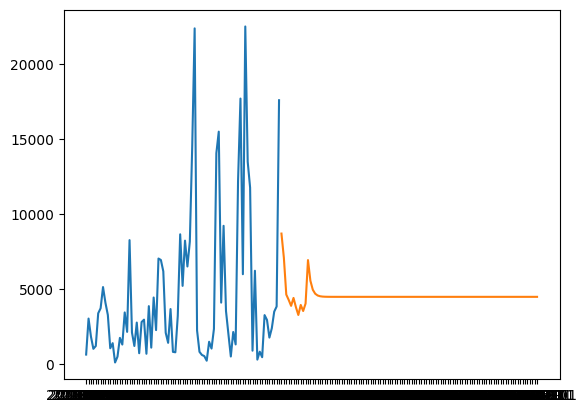

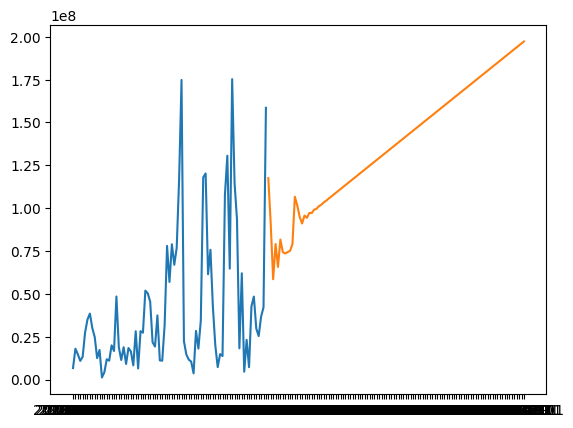

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_db = pd.read_csv('count_sarima_9.csv')
data_sarima = pd.read_csv('forecast_sarima_9.csv')

print(data_db.shape)
print(data_sarima.shape)

plt.plot(data_db['date'], data_db['count'])
plt.plot(data_sarima.month_date, data_sarima.final_count_forecast)
plt.show()

plt.plot(data_db['date'], data_db['cost'])
plt.plot(data_sarima.month_date, data_sarima.final_cost_forecast)
plt.show()

⚙️Обрабатывается категория fd7bbd78-7654-11eb-a224-00155d42eb06
[2024-12-11 17:40:57] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:57] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:57] [WARNING] Loss не улучшился 2 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 2 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 3 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 2 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 3 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 4 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 2 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 3 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не улучшился 1 эпох подряд
[2024-12-11 17:40:58] [WARNING] Loss не 

KeyboardInterrupt: 

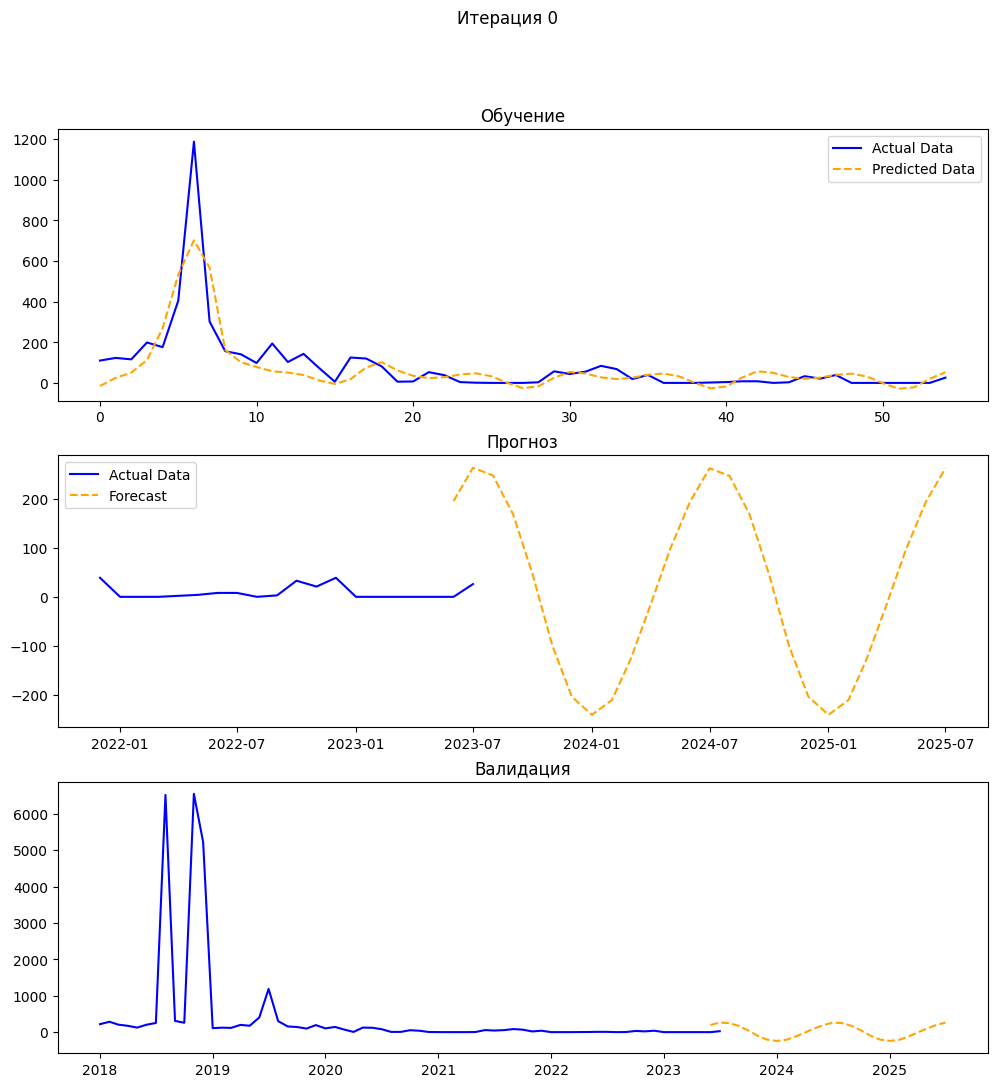

In [46]:
import pandas as pd

from get_data import get_sales, get_count, get_full_data
from version_GRU_tensorboard import run_pipeline


data = pd.read_csv(
    'data_month.csv'
)
predict_df = pd.DataFrame(
    columns=['week_date', 'category_id', 'final_count_forecast', 'final_cost_forecast', 'date_load']
)

for i in data.category_id.unique():
    print(f'⚙️Обрабатывается категория {i}')
    df = data.copy()
    df = df.where((df.category_id == i)).dropna()

    data_count = get_full_data(get_count(df))
    data_cost =  get_full_data(get_sales(df))

    if len(data_count.date) > 20:
        model, forecast_df = run_pipeline(data_count, category=i)
        print(f"    ✅Прогноз количества построен для категории {i}")
    else:
        print(f'    ❌Недостаточно данных количества для категории {i}')

    if len(data_cost.date) > 20:
        model_2, forecast_df_cost = run_pipeline(data_cost, category=i)
        print(f"    ✅Прогноз затрат построен для категории {i}")
    else:
        print(f'    ❌Недостаточно данных затрат для категории {i}')
    count_df = {
        'week_date': forecast_df['Date'],
        'category_id': i,
        'final_count_forecast': forecast_df['Predicted'],
        'final_cost_forecast': forecast_df_cost['Predicted'],
        'date_load': pd.Timestamp.now().strftime("%Y-%m-%d")
    }
    count_df = pd.DataFrame(count_df)
    print(count_df.head())

    predict_df = pd.concat([predict_df, count_df])
    print(f"✅Прогноз построен для категории {i}")

In [4]:
data_db

,date,category_id,product_count,product_cost
0,2020-06-01,fd7bbd78-7654-11eb-a224-00155d42eb06,120,6.606638e+04
1,2023-06-01,6b3b048b-5d64-11e7-8779-00155d03330d,5978,6.468908e+07
2,2020-07-01,fd721057-70e6-11e2-b24e-00155d030b1f,237228,3.879356e+08
3,2019-11-01,01e63094-47a5-11e4-b3d3-00155d031202,5858,4.226390e+06
4,2020-09-01,a7f2fffa-6d0d-11e3-a9db-00155d031202,77111,1.015750e+08
...,...,...,...,...
70379,2020-12-01,b61594fd-d107-11ec-8fb8-00155d8ed20b,641,3.339452e+07
70380,2019-09-01,99851bc8-3330-11e8-9dc5-00155d03330d,271,1.178251e+06
70381,2019-12-01,bfcc1b01-1a11-11e5-838a-00155d03361b,1211,3.687196e+07
70382,2018-06-01,ea42626c-778a-11e5-9edf-00155d03361b,3482,1.509510e+06


In [43]:
data_sarima

,month_date,category_id,final_count_forecast,final_cost_forecast,date_load
0,2024-10-01,6b3b048b-5d64-11e7-8779-00155d03330d,8690.676922,1.174964e+08,2024-12-11
1,2024-11-01,6b3b048b-5d64-11e7-8779-00155d03330d,7077.441424,9.054746e+07,2024-12-11
2,2024-12-01,6b3b048b-5d64-11e7-8779-00155d03330d,4621.358721,5.850418e+07,2024-12-11
3,2025-01-01,6b3b048b-5d64-11e7-8779-00155d03330d,4263.268188,7.906335e+07,2024-12-11
4,2025-02-01,6b3b048b-5d64-11e7-8779-00155d03330d,3868.121120,6.569000e+07,2024-12-11
...,...,...,...,...,...
102,2033-04-01,6b3b048b-5d64-11e7-8779-00155d03330d,4468.469302,1.927230e+08,2024-12-11
103,2033-05-01,6b3b048b-5d64-11e7-8779-00155d03330d,4468.469302,1.938552e+08,2024-12-11
104,2033-06-01,6b3b048b-5d64-11e7-8779-00155d03330d,4468.469302,1.949875e+08,2024-12-11
105,2033-07-01,6b3b048b-5d64-11e7-8779-00155d03330d,4468.469302,1.961197e+08,2024-12-11


In [61]:
data = pd.read_csv('lstm_predict.csv')
data['date'] = data['week_date']

data['final_count_forecast'] = data['final_count_forecast'].apply(lambda x : 0 if (x < 0) else x)
data['final_cost_forecast'] = data['final_cost_forecast'].apply(lambda x : 0 if (x < 0) else x)
mdata

,week_date,category_id,final_count_forecast,final_cost_forecast,date_load,date
0,2024-10-01,fd721048-70e6-11e2-b24e-00155d030b1f,326734.568989,0.000000e+00,2024-12-09,2024-10-01
1,2024-11-01,fd721048-70e6-11e2-b24e-00155d030b1f,981471.875232,0.000000e+00,2024-12-09,2024-11-01
2,2024-12-01,fd721048-70e6-11e2-b24e-00155d030b1f,750951.274190,0.000000e+00,2024-12-09,2024-12-01
3,2025-01-01,fd721048-70e6-11e2-b24e-00155d030b1f,513608.144313,0.000000e+00,2024-12-09,2025-01-01
4,2025-02-01,fd721048-70e6-11e2-b24e-00155d030b1f,466333.381614,0.000000e+00,2024-12-09,2025-02-01
...,...,...,...,...,...,...
1035,2021-12-01,c83bc194-7722-11ef-926f-0050569d5825,0.000000,1.364616e+07,2024-12-09,2021-12-01
1036,2022-01-01,c83bc194-7722-11ef-926f-0050569d5825,0.000000,1.091569e+07,2024-12-09,2022-01-01
1037,2022-02-01,c83bc194-7722-11ef-926f-0050569d5825,0.000000,1.076082e+07,2024-12-09,2022-02-01
1038,2022-03-01,c83bc194-7722-11ef-926f-0050569d5825,1975.937837,1.452662e+07,2024-12-09,2022-03-01


In [1]:
import pandas as pd

df = pd.read_csv('prophet_predict.csv')
df

,date,category_id,count_forecast,cost_forecast,date_load
0,2023-06-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.000000,0.000000,2024-12-09
1,2023-07-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.000000,0.000000,2024-12-09
2,2023-08-01,fd7bbd78-7654-11eb-a224-00155d42eb06,950.058977,132092.795171,2024-12-09
3,2023-09-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.000000,0.000000,2024-12-09
4,2023-10-01,fd7bbd78-7654-11eb-a224-00155d42eb06,0.000000,0.000000,2024-12-09
...,...,...,...,...,...
34991,2023-03-01,d4fea614-c024-11ea-a211-00155d03332b,0.000000,0.000000,2024-12-09
34992,2023-04-01,d4fea614-c024-11ea-a211-00155d03332b,0.000000,0.000000,2024-12-09
34993,2023-05-01,d4fea614-c024-11ea-a211-00155d03332b,0.000000,0.000000,2024-12-09
34994,2023-06-01,d4fea614-c024-11ea-a211-00155d03332b,0.000000,0.000000,2024-12-09


In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv('forecast_prophet_final.csv')
data_db = pd.read_csv('data_month.csv')
data['date'] = data['date']

data['count_forecast'] = data['count_forecast'].apply(lambda x : 0 if (x < 0) else x)
data['cost_forecast'] = data['cost_forecast'].apply(lambda x : 0 if (x < 0) else x)

df = pd.merge(data_db, data, how='inner', on=['date', 'category_id'])

scaler = StandardScaler()

df.count_forecast = scaler.fit_transform(pd.DataFrame(df.count_forecast))
df.cost_forecast = scaler.fit_transform(pd.DataFrame(df.cost_forecast))
df.product_count = scaler.fit_transform(pd.DataFrame(df.product_count))
df.product_cost = scaler.fit_transform(pd.DataFrame(df.product_cost))

print(f'MAPE для количества = {mean_absolute_error(df.count_forecast, df.product_count) * 100:.3f}%')
print(f'MAPE для затрат = {mean_absolute_error(df.cost_forecast, df.product_cost) * 100:.3f}%')

data.to_csv('prophet_predict.csv', index=False)

MAPE для количества = 20.932%
MAPE для затрат = 6.692%


In [65]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

df = pd.merge(data_db, data_sarima, how='inner', on=['date', 'category_id'])

scaler = StandardScaler()

df.Count = scaler.fit_transform(pd.DataFrame(df.Count))
df.Cost = scaler.fit_transform(pd.DataFrame(df.Cost))
df.product_count = scaler.fit_transform(pd.DataFrame(df.product_count))
df.product_cost = scaler.fit_transform(pd.DataFrame(df.product_cost))

print(f'MAPE для количества = {mean_absolute_error(df.Count, df.product_count) * 100:.3f}%')
print(f'MAPE для затрат = {mean_absolute_error(df.Cost, df.product_cost) * 100:.3f}%')

MAPE для количества = 21.292%
MAPE для затрат = 10.082%


In [45]:
df = pd.merge(data_db, data_sarima, how='inner', on=['date', 'category_id'])

df.date = pd.to_datetime(df.date)

df = df.drop(['Date'], axis=1)

In [46]:
df

,date,category_id,product_count,product_cost,Count,Cost,date_load
0,2024-11-01,ced6eef1-8eeb-11e4-88cf-00155d03361b,307,2.437194e+05,344.867322,1.031495e+06,2024-12-08
1,2024-10-01,1e7d456c-61cf-11eb-a214-00155d03332b,74,5.377934e+05,377.704545,9.691988e+05,2024-12-08
2,2024-11-01,49df3f1a-bc20-11ea-a211-00155d03332b,67,4.826080e+05,77.531926,3.897831e+05,2024-12-08
3,2024-11-01,5570e510-98b4-11ef-9293-0050569d5825,496,3.811951e+05,1110.335706,7.947812e+05,2024-12-08
4,2024-10-01,18341a4b-4708-11ee-9130-00155d8ed20b,64420,1.461436e+08,71141.340527,2.349233e+08,2024-12-08
...,...,...,...,...,...,...,...
1939,2024-11-01,7fa98578-bc05-11ea-a211-00155d03332b,2,9.480000e+02,0.000000,0.000000e+00,2024-12-08
1940,2024-11-01,39efb049-4b6a-11ec-8f33-00155d8ed20b,942,1.327699e+07,10177.602629,1.754857e+08,2024-12-08
1941,2024-10-01,f5be1c77-d896-11e2-9b85-00155d030b1f,75742,8.266794e+07,72986.183433,5.294988e+07,2024-12-08
1942,2024-10-01,72cc2004-0235-11e7-981c-00155d03330d,394,1.272892e+07,334.581496,9.349350e+06,2024-12-08


In [67]:
forecast = pd.DataFrame(
    {
        'date': df.date,
        'category_id': df.category_id,
        'count_fact': df.product_count,
        'count_forecast': df.final_count_forecast,
        'cost_fact': df.product_cost,
        'cost_forecast': df.final_cost_forecast
    }
)

forecast.to_csv('forecast_data_fact_norm_lstm .csv', index=False)

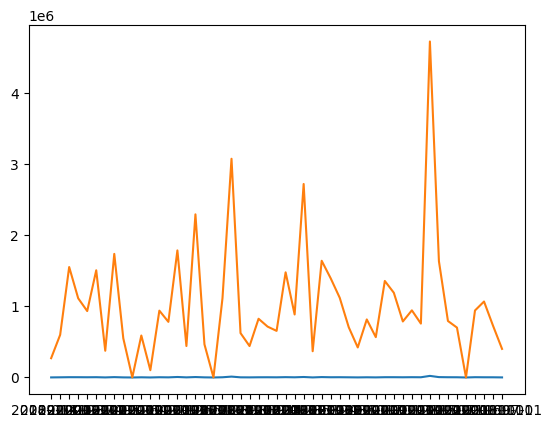

In [70]:
import matplotlib.pyplot as plt

df1 = data_db.where(data_db.category_id == '498012e1-b886-11e3-abb8-00155d031202').dropna()
plt.plot(df1.date, df1.product_count)
plt.plot(df1.date, df1.product_cost)

In [44]:
forecast

,date,category_id,count_fact,count_forecast,cost_fact,cost_forecast
1,2024-10-01,1e7d456c-61cf-11eb-a214-00155d03332b,74.0,377.704545,5.377934e+05,9.691988e+05
4,2024-10-01,18341a4b-4708-11ee-9130-00155d8ed20b,64420.0,71141.340527,1.461436e+08,2.349233e+08
8,2024-10-01,a5833dd4-b6c4-11e7-938d-00155d03330d,23.0,1698.129343,4.599129e+04,2.065852e+06
10,2024-10-01,05583020-70e7-11e2-b24e-00155d030b1f,26064.0,13644.793297,2.377560e+08,1.836957e+08
13,2024-10-01,24f0d333-7e48-11e2-82d4-00155d030b1f,197149.0,205862.865245,2.753730e+07,2.746744e+07
...,...,...,...,...,...,...
1934,2024-10-01,c2f6c971-49d9-11e8-9dc5-00155d03330d,10332.0,24601.708935,4.447629e+07,9.958092e+07
1937,2024-10-01,3c703664-5d48-11ec-8f48-00155d8ed20b,28388.0,18285.560483,3.162438e+06,1.651725e+06
1941,2024-10-01,f5be1c77-d896-11e2-9b85-00155d030b1f,75742.0,72986.183433,8.266794e+07,5.294988e+07
1942,2024-10-01,72cc2004-0235-11e7-981c-00155d03330d,394.0,334.581496,1.272892e+07,9.349350e+06


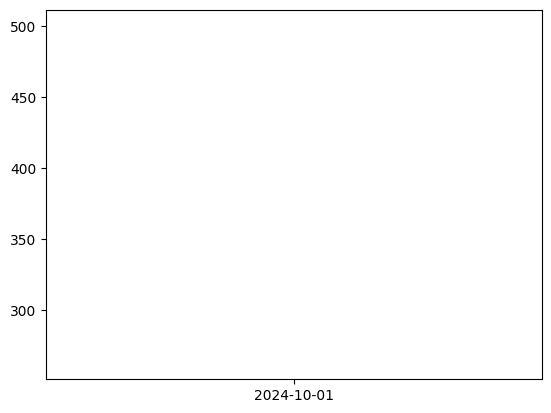

In [75]:
df2 = pd.read_csv('forecast_data_fact_norm.csv')
df2 =  df2.where(df2.category_id == '97caf917-85a7-11ed-9077-00155d8ed20c').dropna()

plt.plot(df2.date, df2.count_fact)
plt.plot(df2.date, df2.count_forecast)